<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/bone_scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom pynrrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# DATA PREPROCESSING
from glob import glob
import numpy as np
import pydicom, cv2, os, copy, shutil, nrrd
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
import matplotlib.pyplot as plt
from PIL import Image
from random import randint

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model
from skimage.metrics import structural_similarity as ssim

In [3]:
img_list = sorted(glob("/content/drive/MyDrive/BONESCAN/data/image/*.dcm"))
msk_list = sorted(glob("/content/drive/MyDrive/BONESCAN/data/mask/*.nrrd"))

# for elem in img_list:
#     print(elem)

# for elem in msk_list:
#     print(elem)

length = len(img_list)

for i in range(length):
    if (os.path.basename(img_list[i][:-4])!=os.path.basename(msk_list[i][:-5])):
        print(os.pth.basename(img_list[i]))
    else:
        pass

img_objs_ant = []
msk_objs_ant = []

img_objs_pos = []
msk_objs_pos = []

for i in range(length):
    temp_obj = pydicom.dcmread(img_list[i])
    temp_arr = temp_obj.pixel_array
    img_objs_ant.append(temp_arr[0])
    img_objs_pos.append(temp_arr[1])

In [4]:
for i in range(length):
    temp2_obj, header = nrrd.read(msk_list[i])
    temp_obj = np.transpose(temp2_obj,(2,1,0))
    msk_objs_ant.append(temp_obj[0])
    msk_objs_pos.append(temp_obj[1])

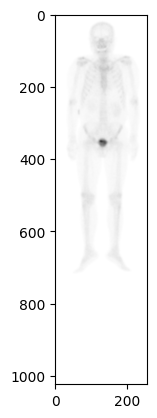

In [5]:
plt.imshow(img_objs_ant[0],interpolation='bicubic',cmap="gray_r")

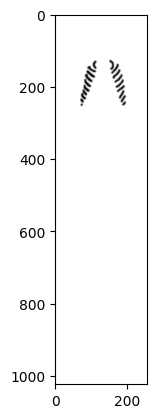

In [6]:
plt.imshow(msk_objs_ant[0],interpolation='bicubic',cmap='gray_r')

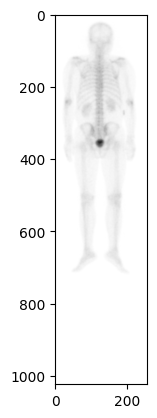

In [7]:
plt.imshow(img_objs_pos[0],interpolation='bicubic',cmap="gray_r")

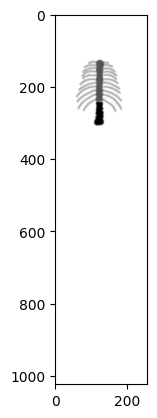

In [8]:
plt.imshow(msk_objs_pos[0],interpolation='bicubic',cmap='gray_r')

In [9]:
print("Anterior img max value      : ", np.max(img_objs_ant[0]))
print("Posterior img max value     : ", np.max(img_objs_pos[0]))

print("Anterior mask unique values : ", np.unique(msk_objs_ant[0]))
print("Posterior mask unique values: ", np.unique(msk_objs_pos[0]))

Anterior img max value      :  250
Posterior img max value     :  163
Anterior mask unique values :  [0 1]
Posterior mask unique values:  [0 1 2 3]


In [ ]:
for i in range(37):
    plt.imshow(msk_objs_pos[i], interpolation='bicubic', cmap='gray_r')
    plt.show()

In [10]:
train_imgs = np.array(img_objs_ant[:50])
train_msks = np.array(msk_objs_ant[:50])
valid_imgs = np.array(img_objs_ant[50:])
valid_msks = np.array(msk_objs_ant[50:])

In [11]:
train_imgs[train_imgs>=100] = 100
valid_imgs[valid_imgs>=100] = 100

In [12]:
train_imgs = np.array(train_imgs, dtype=np.float32)
train_msks = np.array(train_msks, dtype=np.float32)
valid_imgs = np.array(valid_imgs, dtype=np.float32)
valid_msks = np.array(valid_msks, dtype=np.float32)

train_msks = np.reshape(train_msks, (*train_msks.shape, 1))
valid_msks = np.reshape(valid_msks, (*valid_msks.shape, 1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_msks))
test_dataset = tf.data.Dataset.from_tensor_slices((valid_imgs, valid_msks))

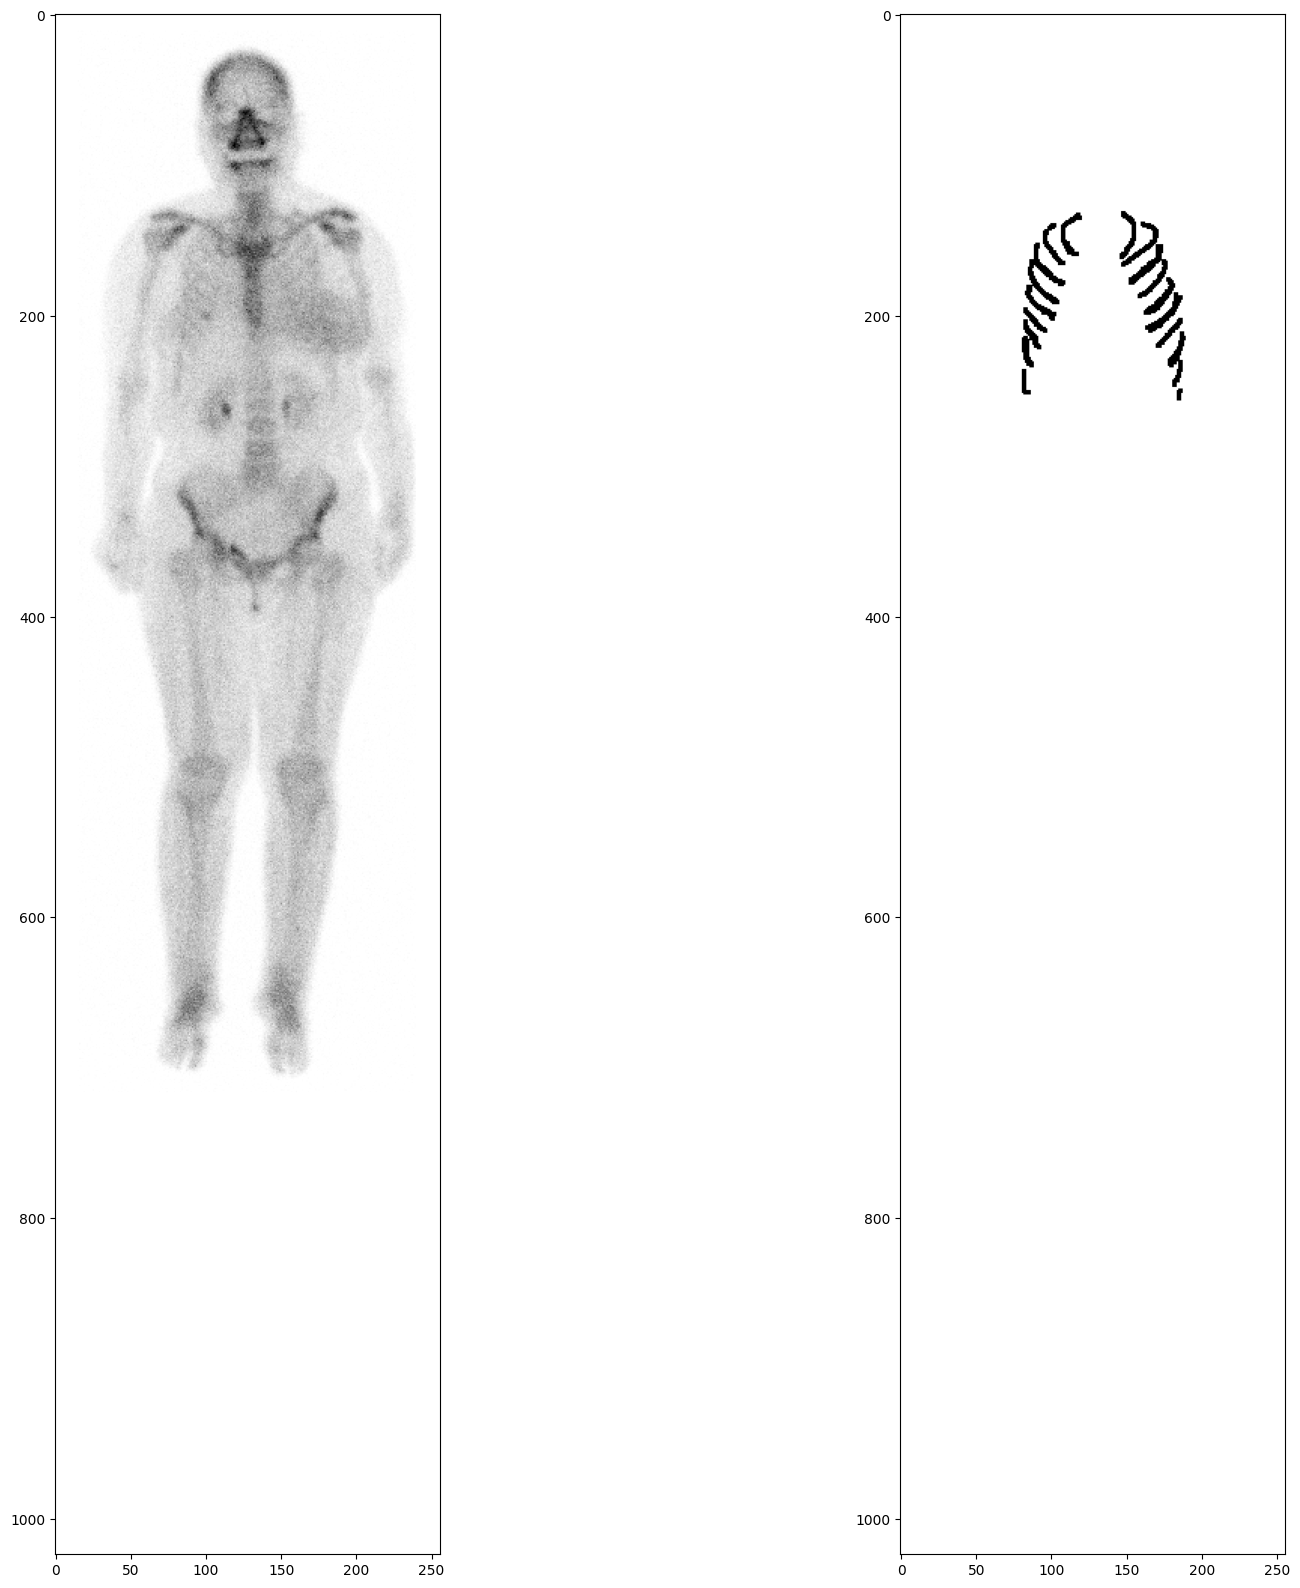

In [13]:
%matplotlib inline

rand_num = randint(1,len(train_imgs))

fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[rand_num], cmap='gray_r')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_msks[rand_num]), cmap='gray_r')

In [ ]:
del model

In [14]:
print(np.shape(train_imgs[1]))

(1024, 256)


In [15]:
inputs = Input((1024, 256, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 256,   0           []                               
                                1)]                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 256, 1  4          ['input_1[0][0]']                
 alization)                     )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 256, 3  320         ['batch_normalization[0][0]']    
                                2)                                                            

In [18]:
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss / 2.0

In [19]:
initial_learning_rate = 5e-6

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath="mymodel_{epoch}.h5",
    save_best_only=True,
    monitor='val_loss',
    verbose=1)]

In [20]:
model.compile(Adam(learning_rate=lr_schedule), bce_dice_loss, metrics=[binary_crossentropy, generalized_dice_coefficient])

In [22]:
model.fit(train_imgs, train_msks, batch_size=10, epochs=50, callbacks=callbacks, validation_data=(valid_imgs, valid_msks))

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.8255 - binary_crossentropy: 0.6721 - generalized_dice_coefficient: 0.0210
Epoch 1: val_loss improved from inf to 0.81868, saving model to mymodel_1.h5
5/5 [==============================] - 29s 2s/step - loss: 0.8255 - binary_crossentropy: 0.6721 - generalized_dice_coefficient: 0.0210 - val_loss: 0.8187 - val_binary_crossentropy: 0.6565 - val_generalized_dice_coefficient: 0.0188
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.8250 - binary_crossentropy: 0.6710 - generalized_dice_coefficient: 0.0210
Epoch 2: val_loss did not improve from 0.81868
5/5 [==============================] - 3s 712ms/step - loss: 0.8250 - binary_crossentropy: 0.6710 - generalized_dice_coefficient: 0.0210 - val_loss: 0.8212 - val_binary_crossentropy: 0.6620 - val_generalized_dice_coefficient: 0.0194
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.8245 - binary_crossentropy: 0.6699 - generalized_dice_coeffi

In [23]:
test_img = valid_imgs[1]

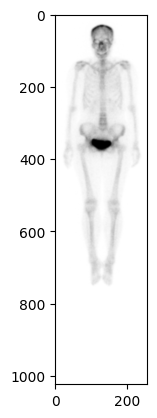

In [24]:
plt.imshow(test_img, interpolation='bicubic', cmap='gray_r')

In [25]:
test_img[test_img>100] = 100

In [26]:
out = model.predict(np.array([test_img]))

1/1 [==============================] - 1s 1s/step


In [27]:
np.shape(out)

(1, 1024, 256, 1)

In [28]:
out = np.squeeze(out)

In [29]:
np.shape(out)

(1024, 256)

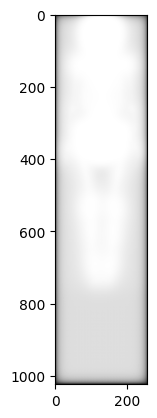

In [30]:
plt.imshow(out, interpolation='bicubic', cmap='gray_r')

In [31]:
out[out<0.005]=0
out[out>=0.005]=1

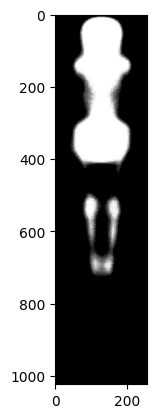

In [32]:
plt.imshow(out, interpolation='bicubic', cmap='gray_r')

In [ ]:
np.unique(out)

array([0., 1.], dtype=float32)

# 쉘에서 실행하기

In [ ]:
import pydicom
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import keras.backend as K
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss / 2.0

root = "C:\\Users\\Administrator\\Downloads\\mymodel_50.h5"

custom_objects = {"dice_coef":dice_coef, "generalized_dice_coefficient":generalized_dice_coefficient,"dice_loss":dice_loss,"bce_dice_loss":bce_dice_loss}

with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model(root)

AttributeError: ignored